# Datasets

In [1]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt

In [10]:
import torch
if torch.backends.mps.is_available():
    mps_device = torch.device("mps")
    x = torch.ones(1, device=mps_device)
    print (x)
else:
    print ("MPS device not found.")

tensor([1.], device='mps:0')


### Dataset Downloading

In [2]:
# Define transformation (convert to tensor and normalize)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load the MNIST dataset
train_dataset = datasets.MNIST(root='./Datasets', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./Datasets', train=False, download=True, transform=transform)

shape của sample đầu tiên: torch.Size([1, 28, 28])
nhãn của sample đầu tiên: 5


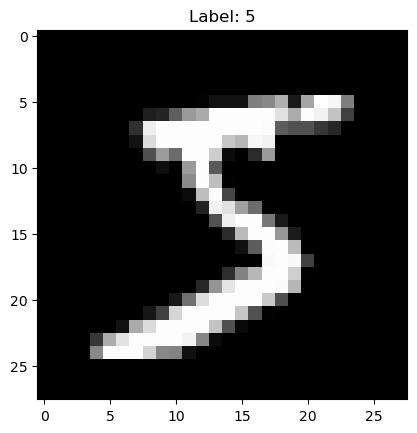

In [3]:
print(f"shape của sample đầu tiên: {train_dataset[0][0].shape}")
print(f"nhãn của sample đầu tiên: {train_dataset[0][1]}")

plt.imshow(train_dataset[0][0].squeeze(), cmap="gray")
plt.title(f"Label: {train_dataset[0][1]}")
plt.show()

### Prepare DataLoader

In [4]:
Batch_size = 64

# Create DataLoader for training and testing
train_loader = DataLoader(train_dataset, batch_size=Batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=Batch_size, shuffle=False)

# Get a batch of training data
images, labels = next(iter(train_loader))

print("Image batch shape:", images.shape)   # torch.Size([64, 1, 28, 28])
print("Label batch shape:", labels.shape)   # torch.Size([64])

Image batch shape: torch.Size([64, 1, 28, 28])
Label batch shape: torch.Size([64])


# Model

In [5]:
class SoftmaxRegression(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = torch.nn.Flatten()
        self.linear = torch.nn.Linear(28 * 28, 10)

    def forward(self, x):
        x = self.flatten(x)
        return self.linear(x)

In [6]:
# Initialize the model
model = SoftmaxRegression()
print(model)

# Define loss function and optimizer
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

SoftmaxRegression(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear): Linear(in_features=784, out_features=10, bias=True)
)


In [7]:
import matplotlib.pyplot as plt

num_epochs = 5  # feel free to increase
train_losses = []
test_losses = []

for epoch in range(num_epochs):
    # Training
    model.train()
    train_loss = 0

    for batch, (X, y) in enumerate(train_loader):
        logits = model(X)
        loss = loss_fn(logits, y)
        train_loss += loss.item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    # Evaluation
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for X, y in test_loader:
            logits = model(X)
            loss = loss_fn(logits, y)
            test_loss += loss.item()

    test_loss /= len(test_loader)
    test_losses.append(test_loss)

    # Print
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}")


Epoch 1/5, Train Loss: 0.6124, Test Loss: 0.4052
Epoch 2/5, Train Loss: 0.3862, Test Loss: 0.3471
Epoch 3/5, Train Loss: 0.3520, Test Loss: 0.3262
Epoch 4/5, Train Loss: 0.3348, Test Loss: 0.3159
Epoch 5/5, Train Loss: 0.3236, Test Loss: 0.3054


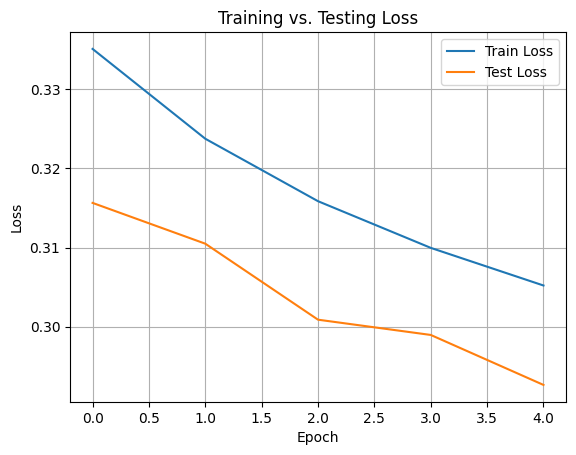

In [22]:
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs. Testing Loss')
plt.legend()
plt.grid(True)
plt.show()
